<a href="https://colab.research.google.com/github/KenzaAHMIA/RNN/blob/main/KenzaShami_ScriptRNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Reconnaissance de langue avec Keras
## L'emploi de réseaux de neurones convolutif (CNN) pour **la reconnaissance langues** : anglais, arabe, espagnol et français



In [ ]:
# @title Importation des données depuis le drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# @title Les chemins vers les fichiers train et test
import os
import glob
from pprint import pprint
list_train = glob.glob('../CNN/languageRecognition/train/*/*')
list_test = glob.glob('../CNN/languageRecognition/test/*/*')


In [ ]:
# Vérification
print("Liste train :", len(list_train))
print("Liste_test : ", len(list_test))

Liste train : 4680
Liste_test :  520


In [ ]:
# @title Import des bibiliothèques et paramétrages
import keras
from __future__ import print_function
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, BatchNormalization, Activation
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras import backend as K
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.optimizers import Adadelta
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import LabelBinarizer
from keras.preprocessing.image import ImageDataGenerator

In [ ]:
# @title Définition des paramètres
batch_size = 32
num_classes = 4  # 4 langues - multicatégorie
epochs = 30

# Labels
labels = ['ar', 'en', 'es', 'fr']

# input image dimensions
img_rows, img_cols = 28, 28

In [ ]:
# @title Mise en forme des données
import numpy as np
import cv2

# Création d'un objet LabelEncoder
label_encoder = LabelEncoder()

# Initialisation des listes pour les données d'entraînement et de test
x_train= []
y_train = []

x_test = []
y_test = []

# Fonction pour diviser les données en ensembles d'entraînement et de test
def split_data(x_list, y_list, dataList):
    for path in dataList:
        x = cv2.imread(path,0).astype(np.uint8) #unsigned int

        # Redimensionner les images à la taille spécifiée
        x = cv2.resize(x, (img_rows, img_cols))

        # Extraire le label de la langue à partir du chemin du fichier
        y = path.split('/')[-2] # ar en es fr

        x_list.append(x)
        y_list.append(y) # listes de langues

    return x_list, y_list

In [ ]:
# @title  Split Train et Test Data - images et étiquettes -
# Utilisation de la fonction 'split_data'

# x_train contiendra les images d'entraînement et y_train les labels correspondants
x_train, y_train = split_data(x_list=[], y_list=[],dataList=list_train)

# x_test contiendra les images de test et y_test les labels correspondants
x_test, y_test = split_data(x_list=[], y_list=[], dataList = list_test)


In [ ]:
# Verification
print('Longueur de x_train et y_train :', len(x_train), len(y_train))
print('Longueur de x_test et y_test :' , len(x_test), len(y_test))

Longueur de x_train et y_train : 4680 4680
Longueur de x_test et y_test : 520 520


In [ ]:
# @title Conversion des étiquettes (ar en es fr) en valeurs numériques

# Création d'une instance de LabelEncoder
label_encoder = LabelEncoder()

# Conversion des étiquettes d'entraînement en valeurs numériques
y_train = label_encoder.fit_transform(y_train)
print(y_train.shape)

# Conversion des étiquettes de test en valeurs numériques
y_test = label_encoder.fit_transform(y_test)
print(y_test.shape)

(4680,)
(520,)


In [ ]:
# @title Conversion en numPy Array
import numpy as np

# Conversion des listes x_train et x_test en tableaux NumPy
x_train = np.array(x_train)
x_test = np.array(x_test)

print("x_train shape : ",(x_train.shape))
print("x_test shape : ",(x_test.shape))

x_train shape :  (4680, 28, 28)
x_test shape :  (520, 28, 28)


In [ ]:
# @title Reshaping data
# Vérification du format des données d'image

# Affichage des formes initiales des données
print("Formes initiales des données : ")
print(f" x_train shape = {x_train.shape}\n y_train shape = {y_train.shape} \n x_test shape = {x_test.shape}\n y_text.shape = {y_test.shape}")

if K.image_data_format() == 'channels_first': # order = color channel first , width , length
    # Si le format est 'channels_first', ajuster la forme des données d'entraînement et de test
    x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols) # n_occ, rows, col, 1 ->n_occ = -1 calcule lui même le nombre d'occ
    x_test = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols) # Nouvelle forme pour le format 'channels_first'

else:
    # Sinon ajuster la forme des données d'entraînement et de test
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1) # (width, length, color channel)

# Affichage des formes finales des données après le remodelage
print("\n\nFormes finales des données après remodlage: ")
print(f" x_train shape = {x_train.shape}\n y_train shape = {y_train.shape} \n x_test shape = {x_test.shape}\n y_text.shape = {y_test.shape}")


Formes initiales des données : 
 x_train shape = (4680, 28, 28)
 y_train shape = (4680,) 
 x_test shape = (520, 28, 28)
 y_text.shape = (520,)


Formes finales des données après remodlage: 
 x_train shape = (4680, 28, 28, 1)
 y_train shape = (4680,) 
 x_test shape = (520, 28, 28, 1)
 y_text.shape = (520,)


In [ ]:
# @title  Normalisation des données - pixels  - également possible avec BatchNormalization:

# Conversion des valeurs des pixels en float32 (plus précis que uint8)
x_train = x_train.astype('float32') # dt of pixel values
x_test = x_test.astype('float32')# impression

In [ ]:
# @title Image Labels train and test # TOURNER UNE SEULE FOIS
# Conversion des étiquettes en catégories (one-hot encoding)
# 'to_categorical' transforme les étiquettes en vecteurs binaires
# avec une seule position à 1 pour la classe correspondante
y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)

In [ ]:
# @title Vérification des classes et échantillons
print(f"Nombre d'échantillons et de classes dans y_train : {y_train.shape}")
print(f"Nombre d'échantillons et de classes dans y_test : {y_test.shape}")

Nombre d'échantillons et de classes dans y_train : (4680, 4)
Nombre d'échantillons et de classes dans y_test : (520, 4)


In [ ]:
# @title Layers
model = Sequential()

# Ajout des couches convolutionnelles et fully connected
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

In [ ]:
# @title Vérification des dimensions
print(f"Dimensions des données d'entraînement : {x_train.shape}")
print(f"Dimensions des labels d'entraînement : {y_train.shape}")

print(f"\nDimensions des données de test : {x_test.shape}")
print(f"Dimensions des labels de test : {y_test.shape}")

Dimensions des données d'entraînement : (4680, 28, 28, 1)
Dimensions des labels d'entraînement : (4680, 4)

Dimensions des données de test : (520, 28, 28, 1)
Dimensions des labels de test : (520, 4)


In [ ]:
# @title Compilation et Fit/Entraînement du modèle

# @title Fonction 1 - Compilation du modèle
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

# @title Fonction 2 - Entraînement du modèle
# La fonction fit() effectue l'entraînement du modèle sur les données d'entraînement
# et renvoie un objet history qui contient des informations sur la formation
history = model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,  # Affiche la progression de l'apprentissage
          validation_data=(x_test, y_test))

# Evaluation du modèle sur les données de test
score = model.evaluate(x_test, y_test, verbose=0)  # score = perte de test, précision de test
print('Test loss:', score[0])
print('Test accuracy:', score[1])


Epoch 1/30
147/147 [==============================] - 4s 24ms/step - loss: 0.4765 - accuracy: 0.7748 - val_loss: 0.4770 - val_accuracy: 0.7519
Epoch 2/30
147/147 [==============================] - 3s 23ms/step - loss: 0.4146 - accuracy: 0.8019 - val_loss: 0.4887 - val_accuracy: 0.7500
Epoch 3/30
147/147 [==============================] - 5s 31ms/step - loss: 0.4318 - accuracy: 0.8034 - val_loss: 0.4813 - val_accuracy: 0.7385
Epoch 4/30
147/147 [==============================] - 5s 32ms/step - loss: 0.4016 - accuracy: 0.8094 - val_loss: 0.4955 - val_accuracy: 0.7423
Epoch 5/30
147/147 [==============================] - 4s 24ms/step - loss: 0.3829 - accuracy: 0.8169 - val_loss: 0.5168 - val_accuracy: 0.7558
Epoch 6/30
147/147 [==============================] - 3s 22ms/step - loss: 0.3677 - accuracy: 0.8293 - val_loss: 0.5202 - val_accuracy: 0.7500
Epoch 7/30
147/147 [==============================] - 4s 31ms/step - loss: 0.3753 - accuracy: 0.8318 - val_loss: 0.5044 - val_accuracy: 0.7423

In [ ]:
# @title Visualisations

from matplotlib import pyplot as plt
def plot_accuracy_loss(history):

    fig = plt.figure(figsize=(15,8))

    # Plot accuracy
    plt.subplot(221)
    plt.plot(history.history['accuracy'], 'b-', label='accuracy')
    plt.plot(history.history['val_accuracy'], 'm-', label='val_accuracy')
    plt.title("train_acc vs val_acc")
    plt.ylabel("accuracy")
    plt.xlabel("epochs")
    plt.legend()


    # Plot loss function
    plt.subplot(222)
    plt.plot(history.history['loss'], 'r-', label='loss')
    plt.plot(history.history['val_loss'], color='cyan', label='val_loss')
    plt.title("train_loss vs val_loss")
    plt.ylabel("loss")
    plt.xlabel("epochs")


    plt.legend()
    plt.show()

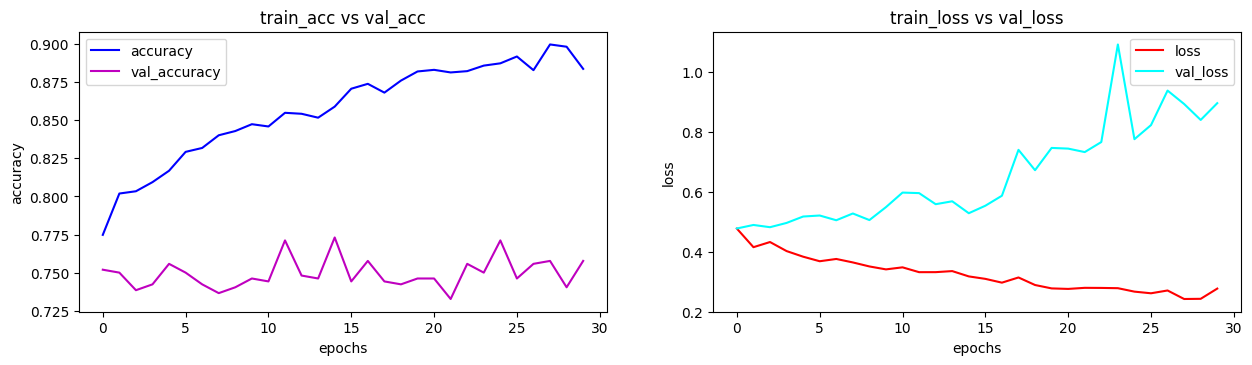

In [ ]:
# @title Appel fonction pour visualisations par epoch
plot_accuracy_loss(history)

In [ ]:
# @title Early Stopping sauvegarde du meilleur model

#model_directory = '/content/drive/My Drive/CNN/languageRecognition/model'
model_directory = '../CNN/ModelBest'

# Créer le répertoire s'il n'existe pas
os.makedirs(model_directory, exist_ok=True)

# Callback pour arrêter l'entraînement prématurément si la perte de validation ne s'améliore pas
from keras.callbacks import EarlyStopping, ModelCheckpoint
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10) # earlyStopping

# Callback pour sauvegarder le meilleur modèle basé sur la perte de validation
#mc = ModelCheckpoint('/content/drive/My Drive/CNN/languageRecognition/model/test_model.h5', monitor='val_loss', mode='min', save_best_only=True)
mc = ModelCheckpoint('../CNN/model_3/ModelBest', monitor='val_loss', mode='min', save_best_only=True)

# Compiler le modèle (si ce n'est pas déjà fait)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model with callbacks
history = model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, verbose=1, validation_split=0.2, callbacks=[es, mc])

# Save the final model (optional)
model.save(os.path.join(model_directory, 'ModelBest'))

# Évaluation du modèle sur les données de test
score = model.evaluate(x_test, y_test, verbose=1)


Epoch 1/30
117/117 [==============================] - 13s 98ms/step - loss: 0.2358 - accuracy: 0.8865 - val_loss: 0.7879 - val_accuracy: 0.5865
Epoch 2/30
117/117 [==============================] - 4s 31ms/step - loss: 0.2487 - accuracy: 0.8841 - val_loss: 0.4504 - val_accuracy: 0.6015
Epoch 3/30
117/117 [==============================] - 3s 24ms/step - loss: 0.2270 - accuracy: 0.8908 - val_loss: 0.5076 - val_accuracy: 0.5994
Epoch 4/30
117/117 [==============================] - 5s 40ms/step - loss: 0.2265 - accuracy: 0.8953 - val_loss: 0.5865 - val_accuracy: 0.5940
Epoch 5/30
117/117 [==============================] - 3s 27ms/step - loss: 0.1980 - accuracy: 0.9076 - val_loss: 0.5360 - val_accuracy: 0.5972
Epoch 6/30
117/117 [==============================] - 3s 24ms/step - loss: 0.2006 - accuracy: 0.9068 - val_loss: 0.5771 - val_accuracy: 0.5929
Epoch 7/30
117/117 [==============================] - 3s 25ms/step - loss: 0.2021 - accuracy: 0.9054 - val_loss: 0.6245 - val_accuracy: 0.580

## Test sur données inconnu

In [ ]:
from keras.models import load_model
import os

# Charger le meilleur modèle
best_model = load_model('/content/drive/MyDrive/MASTER_2_TAL-IM/CNN/Modeltest2')

# Dossier contenant les images mélangées
folder_path = "/content/drive/MyDrive/MASTER_2_TAL-IM/CNN/languageRecognition/eval"


dico = { 'ar' : 0, 'en' : 1, 'es' : 2, 'fr' : 3}

# Liste pour stocker les résultats
predictions_classes = []

# Liste pour stocker les vraies classes
true_classes = []

# taille des images
img_rows = 28
img_cols = 28

# Parcourir toutes les images du dossier
for filename in os.listdir(folder_path):
    if filename.endswith(".png"):  # Assurez-vous que vous ne traitez que les fichiers JPEG (ajustez au besoin)
        # Charger et prétraiter l'image
        image_path = os.path.join(folder_path, filename)
        img = cv2.imread(image_path, 0).astype(np.uint8)
        img = cv2.resize(img, (img_rows, img_cols))
        img_reshaped = img.reshape(1, img_rows, img_cols, 1)
        img_normalized = img_reshaped.astype('float32') / 255

        # Extraire la vraie classe à partir du nom de fichier
        true_class = filename.split('_')[2]  # Supposons que la vraie classe est le premier élément avant le premier '_'
        true_classes.append(dico[true_class])

        # Faire une prédiction avec le modèle
        prediction = best_model.predict(img_normalized)
        predicted_class = np.argmax(prediction)  # Récupérer la classe prédite avec la probabilité la plus élevée

        # Ajouter le résultat à la liste
        predictions_classes.append(predicted_class)


1/1 [==============================] - 0s 37ms/step


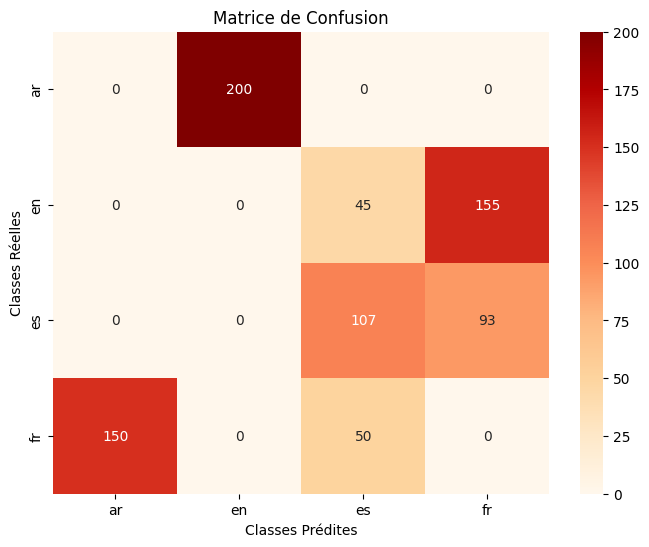

In [ ]:
# @title Matrice de confusion

from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Calculer la matrice de confusion
conf_matrix = confusion_matrix(true_classes, predictions_classes)

# Visualiser la matrice de confusion avec seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='OrRd', xticklabels=list(dico.keys()), yticklabels=list(dico.keys()))
plt.xlabel('Classes Prédites')
plt.ylabel('Classes Réelles')
plt.title('Matrice de Confusion')
plt.show()
